# FYP-DL: Countering Class Imbalance with SMOTE and ADASYN - Random Forest

## **S**ystemic **M**inority **O**versampling **T**echnique
- A form of **data augmentation**.
- Draws a straight 'line' or `n-1`-dimensional hyperplane between examples of the minority class in `n`-dimensional feature space.
- Generates a syntethic training example by choosing a point along the hyperplane. 
- Uses a variant of KNN to find the data points between which the line or hyperplane can be drawn.
- Better than undersampling the majority class because it doesn't decrease the size of the dataset/number of majority class examples.
- Better than oversampling the minority class because it doesn't introduce redundant/duplicate training examples for the minority class.
- Also better than oversampling because oversampled examplse don't add any new information to the dataset.
- This works because the new training examples occupy almost the same regions in the minority class's feature space.
- [This paper](https://arxiv.org/abs/1106.1813) says that undersampling the majority class + SMOTE for minority class --> better performance than standalone undersampling or SMOTE.


## ADASYN
- **A**daptive **S**ynthetic **S**ampling
- Generates new training examples for the minority class in regions of the feature space where the density of the minority class is low. 
- Don't generate minority training examples where the feature space is high.

# Installing `imbalanced-learn`
A libary, much like `scikit-learn` with classes and functions for undersampling, oversampling, and working with imbalanced data.

In [1]:
!pip install imbalanced-learn

# Imports

In [2]:
# Standard imports
import numpy as np
import pandas as pd 
import os
from shutil import copy

# For counting the class division before and after resampling
from collections import Counter

# Seeding random number generator
np.random.seed(0)

# For counting number of samples per class
from collections import Counter

# Colab and Drive integration
from google.colab import drive, files

# For plotting 
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib import style
style.use('ggplot')
from seaborn import countplot

# Scikit-Learn imports
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, \
roc_curve, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split 

# Scikit-Learn - Logistic Regression
from sklearn.ensemble import RandomForestClassifier

# Imbalanced Learn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Mount Google Drive

In [3]:
# Directories
MOUNT_DIR = '/content/drive'
DRIVE_DIR = os.path.join(MOUNT_DIR, 'My Drive')
FYP_DIR = os.path.join(DRIVE_DIR, 'EE 16-17 FYP DL Energy Theft Detection')
DATA_DIR = os.path.join(FYP_DIR, 'Data/full-processing-data')
MODULES_DIR = os.path.join(FYP_DIR, 'Modules')

# Filepaths
DATA_FILE = os.path.join(DATA_DIR, 'outliersRemoved.csv')

In [4]:
drive.mount(MOUNT_DIR, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Modules

Temporarily loading them from Google Drive because GitHub repo is private.

In [5]:
for fname in os.listdir(MODULES_DIR):
  src = os.path.join(MODULES_DIR, fname)
  dst = os.path.join('./', fname)
  copy(src, dst)

In [6]:
from get_classification_result import *

# Reading Data

In [7]:
df = pd.read_csv(DATA_FILE)
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Extracting Features and Labels

In [8]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

# Feature Scaling

In [11]:
from pipelines import get_pipeline_1D

# Creating pipeline objects
pipeline_1D_std = get_pipeline_1D(scaling_strategy='Standard')
pipeline_1D_minmax = get_pipeline_1D(scaling_strategy='MinMax')

# Fit and then transform the pipelines to the training data first 
# Standard Scaling
X_train_1D_std = pipeline_1D_std.fit_transform(X_train)
X_val_1D_std = pipeline_1D_std.fit_transform(X_val)
X_test_1D_std = pipeline_1D_std.fit_transform(X_test)

# MinMax Scaling
X_train_1D_minmax = pipeline_1D_minmax.fit_transform(X_train)
X_val_1D_minmax = pipeline_1D_minmax.fit_transform(X_val)
X_test_1D_minmax = pipeline_1D_minmax.fit_transform(X_test)

# SMOTE

## Class Distribution Before SMOTE

Counter({0: 24803, 1: 2314})


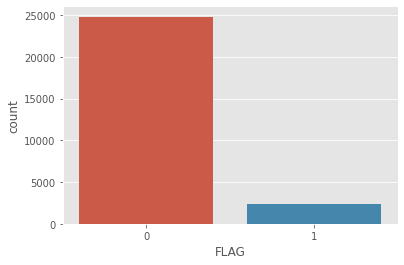

In [12]:
# Prior to any resampling, the data should have a 91.5-8.5 split
counter_original = Counter(y_train)
print(counter_original)
countplot(y_train)

## SMOTE - Standard Scaler Data

In [13]:
# Standard SMOTE that will create synthetic minority samples for 50-50 split
oversample = SMOTE()
X_train_std_smote, y_train_std_smote = oversample.fit_resample(X_train_1D_std, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## SMOTE - MinMax Scaler Data

In [14]:
oversample = SMOTE()
X_train_minmax_smote, y_train_minmax_smote = oversample.fit_resample(X_train_1D_minmax, 
                                                                     y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Class Distribution After SMOTE

In [15]:
# What is the distribution of values after SMOTE?
counter_smote = Counter(y_train_std_smote)
print(counter_smote)

Counter({0: 24803, 1: 24803})


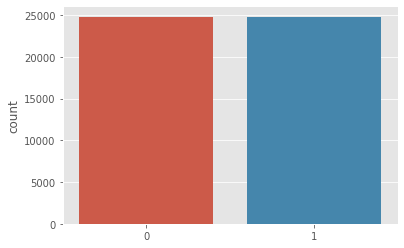

In [16]:
countplot(y_train_std_smote)

As expected, standard `SMOTE` has created new, synthetic training examples for the positive (minority) class so that we now have 31k training examples for both.

# Random Forest with SMOTE

## Standard Scaler Model

### Train Model

In [19]:
# Instantiate a logistic regression model
rf_smote = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)

# Fit to the correct training data
rf_smote.fit(X_train_std_smote, y_train_std_smote)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### Validation Set Results - By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.97      0.95      6202
         Thieves       0.39      0.19      0.26       578

        accuracy                           0.91      6780
       macro avg       0.66      0.58      0.60      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.97210577 0.02789423]
 [0.80622837 0.19377163]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


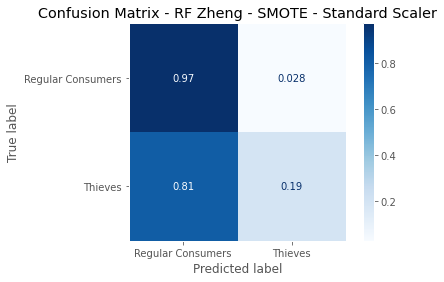

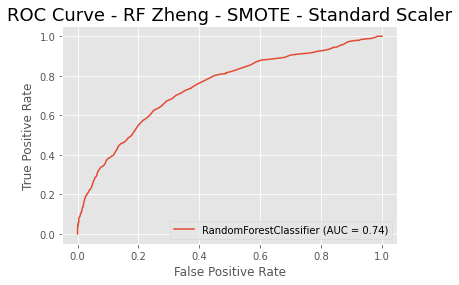

In [20]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE - Standard Scaler", 
                          normalize_conf_mat="rows")

### Validation Set Results - By Col

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.97      0.95      6202
         Thieves       0.39      0.19      0.26       578

        accuracy                           0.91      6780
       macro avg       0.66      0.58      0.60      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.9282525  0.60701754]
 [0.0717475  0.39298246]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


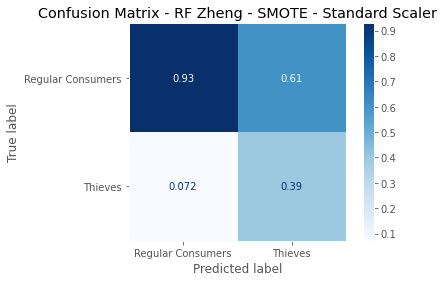

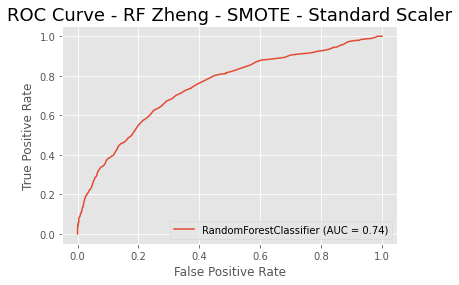

In [21]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE - Standard Scaler", 
                          normalize_conf_mat="cols")

### Validation Set Results - By All

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.97      0.95      6202
         Thieves       0.39      0.19      0.26       578

        accuracy                           0.91      6780
       macro avg       0.66      0.58      0.60      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.88923304 0.02551622]
 [0.06873156 0.01651917]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


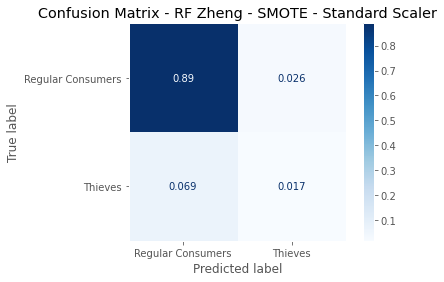

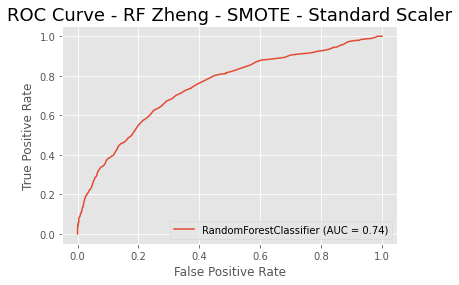

In [22]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE - Standard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

### Train Model

In [23]:
# Instantiate a logistic regression model
rf_smote = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)

# Fit to the correct training data
rf_smote.fit(X_train_minmax_smote, y_train_minmax_smote)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  8.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### Val Results - By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.40      0.18      0.25       578

        accuracy                           0.91      6780
       macro avg       0.66      0.58      0.60      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.97549178 0.02450822]
 [0.82352941 0.17647059]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


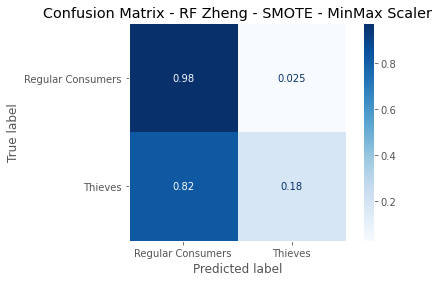

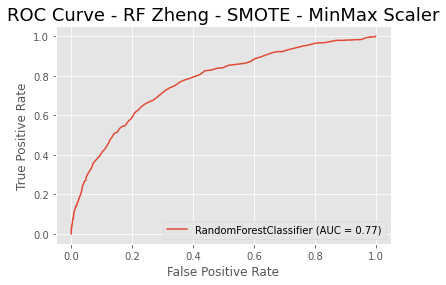

In [24]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE - MinMax Scaler", 
                          normalize_conf_mat="rows")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.15      0.23       578

        accuracy                           0.91      6780
       macro avg       0.70      0.57      0.59      6780
    weighted avg       0.89      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.92543195 0.52747253]
 [0.07456805 0.47252747]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


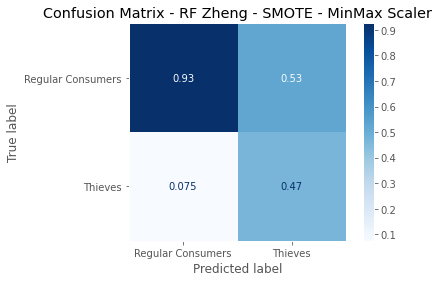

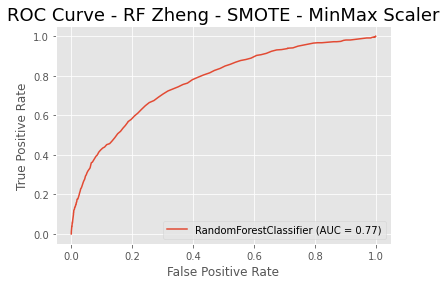

In [63]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE - MinMax Scaler", 
                          normalize_conf_mat="cols")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.15      0.23       578

        accuracy                           0.91      6780
       macro avg       0.70      0.57      0.59      6780
    weighted avg       0.89      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.90058997 0.01415929]
 [0.07256637 0.01268437]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


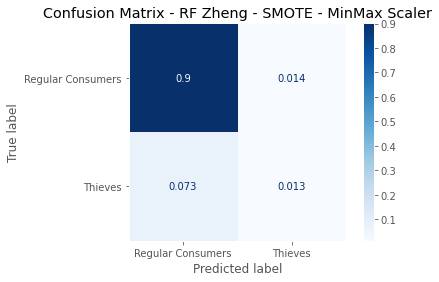

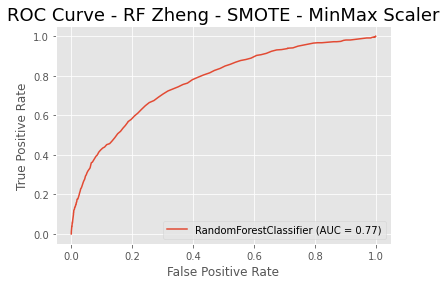

In [64]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE - MinMax Scaler", 
                          normalize_conf_mat="all")

# SMOTE and Majority Undersampling

According to the original research paper on SMOTE, this technique performs better when the majority class is undersampled in conjunction with smote.

In [27]:
# Oversample the minority class to have 40% as many samples as original majority class
oversampler = SMOTE(sampling_strategy=0.4)

# Undersample the minority class to have twice as many samples as minority class
undersampler = RandomUnderSampler(sampling_strategy=0.5)

# Create a pipeline with the two sampling steps
sampling_pipeline = Pipeline([('over', oversampler), ('under', undersampler)])

## Class Distribution Before Resampling

Counter({0: 24803, 1: 2314})


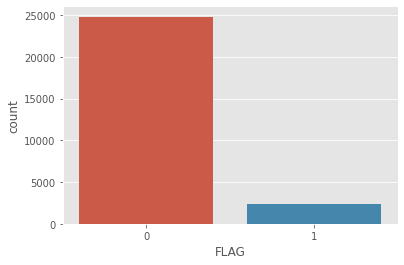

In [28]:
counter = Counter(y_train) 
print(counter)
countplot(y_train)

## Resampling - Standard Scaler Data

In [29]:
X_train_std_resampled, y_train_std_resampled = sampling_pipeline.fit_resample(
    X_train_1D_std, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 19842, 1: 9921})


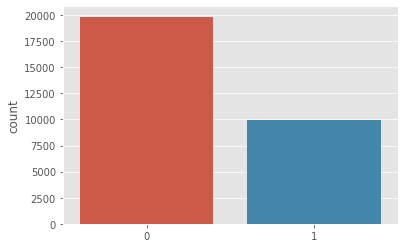

In [30]:
print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

In [31]:
X_train_minmax_resampled, y_train_minmax_resampled = sampling_pipeline.fit_resample(
    X_train_1D_minmax, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 19842, 1: 9921})


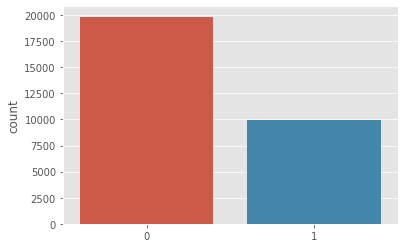

In [32]:
print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# Random Forest with SMOTE + Majority Oversampling

## Standard Scaler Model

In [33]:
# Instantiate Random Forest Classifier
rf_smote = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)

# Fit to the correct training data
rf_smote.fit(X_train_std_resampled, y_train_std_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.46      0.16      0.23       578

        accuracy                           0.91      6780
       macro avg       0.69      0.57      0.59      6780
    weighted avg       0.89      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.98323122 0.01676878]
 [0.84429066 0.15570934]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


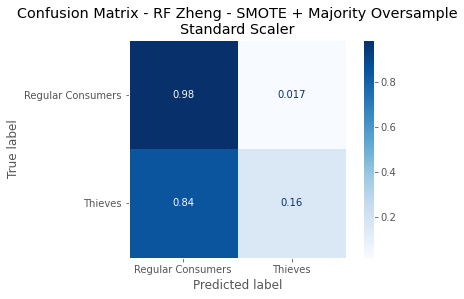

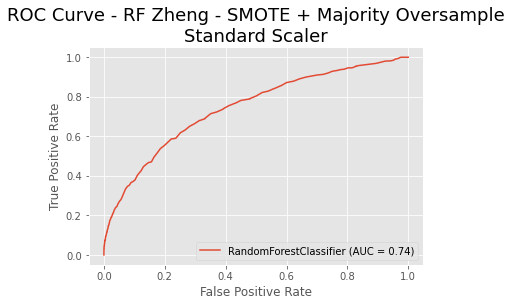

In [34]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE + Majority Oversample\nStandard Scaler", 
                          normalize_conf_mat="rows")

### By Col

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.46      0.16      0.23       578

        accuracy                           0.91      6780
       macro avg       0.69      0.57      0.59      6780
    weighted avg       0.89      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.92590343 0.53608247]
 [0.07409657 0.46391753]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


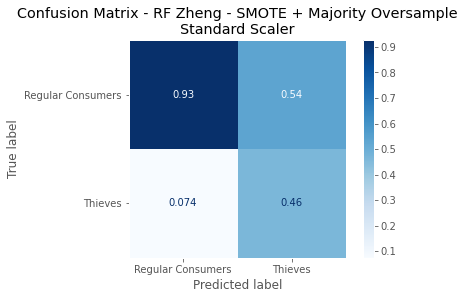

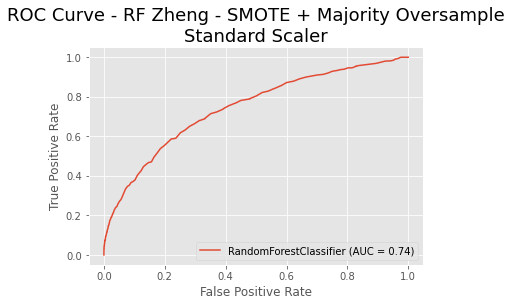

In [35]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE + Majority Oversample\nStandard Scaler", 
                          normalize_conf_mat="cols")

### By All

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.95      6202
         Thieves       0.18      0.00      0.01       578

        accuracy                           0.91      6780
       macro avg       0.55      0.50      0.48      6780
    weighted avg       0.85      0.91      0.87      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.13421829e-01 1.32743363e-03]
 [8.49557522e-02 2.94985251e-04]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


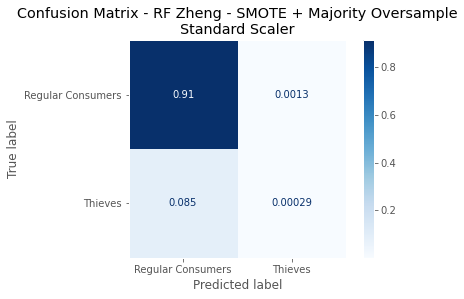

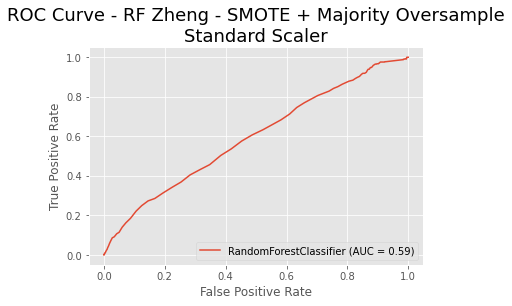

In [65]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE + Majority Oversample\nStandard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

In [37]:
# Instantiate Random Forest Classifier
rf_smote = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)

# Fit to the correct training data
rf_smote.fit(X_train_minmax_resampled, y_train_minmax_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.19      0.27       578

        accuracy                           0.91      6780
       macro avg       0.70      0.58      0.61      6780
    weighted avg       0.89      0.91      0.90      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.98016769 0.01983231]
 [0.81141869 0.18858131]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


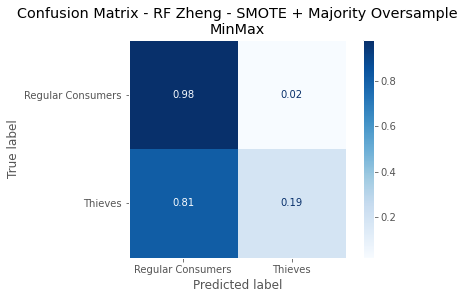

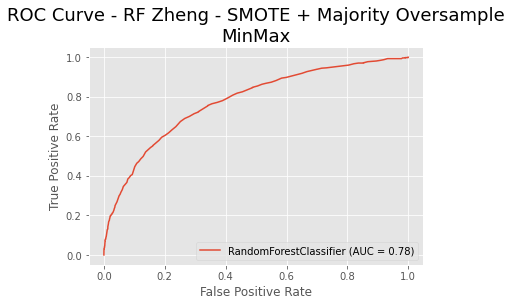

In [38]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE + Majority Oversample\nMinMax", 
                          normalize_conf_mat="rows")

### By Col

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.19      0.27       578

        accuracy                           0.91      6780
       macro avg       0.70      0.58      0.61      6780
    weighted avg       0.89      0.91      0.90      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.92837508 0.53017241]
 [0.07162492 0.46982759]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


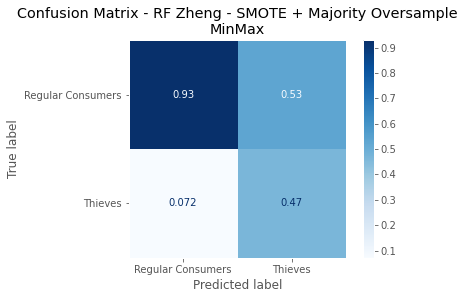

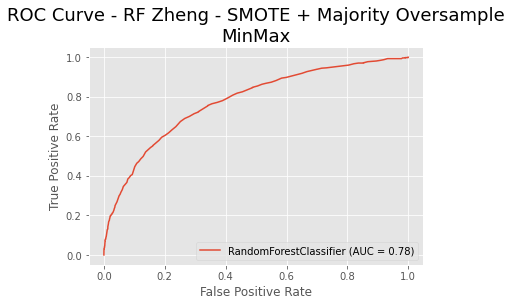

In [39]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE + Majority Oversample\nMinMax", 
                          normalize_conf_mat="cols")

### By All

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.19      0.27       578

        accuracy                           0.91      6780
       macro avg       0.70      0.58      0.61      6780
    weighted avg       0.89      0.91      0.90      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.89660767 0.01814159]
 [0.06917404 0.0160767 ]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


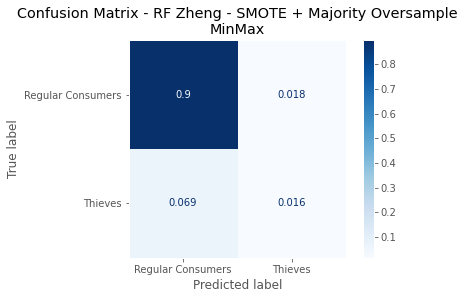

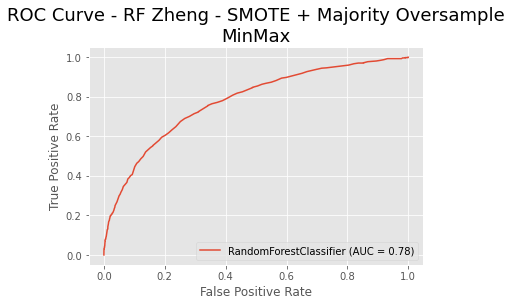

In [40]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - SMOTE + Majority Oversample\nMinMax", 
                          normalize_conf_mat="all")

# Borderline SMOTE

All variants of SMOTE tested so far will generate synthetic samples by drawing samples from the hyperplane between neighbouring examples of the minority class, regardless of how likely these examples are to be misclassified.

Intuitively, it makes more sense to generate synthetic examples only for those training examples or regions of the feature space where classification is difficult.

Borderline SMOTE will generate synthetic samples only for those training examples which are misclassified by a KNN classifier. 

## Resampling - Standard Scaler Data

In [41]:
borderline_smote = BorderlineSMOTE() 
X_train_std_resampled, y_train_std_resampled = borderline_smote.fit_resample(
    X_train_1D_std, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24803})


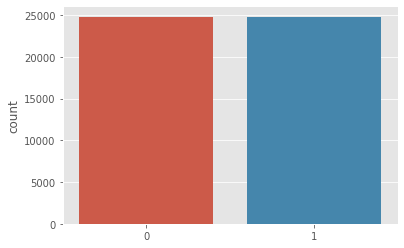

In [42]:
print(Counter(y_train_std_resampled))
countplot(y_train_std_resampled)

## Resampling - MinMax Scaler Data

In [43]:
borderline_smote = BorderlineSMOTE() 
X_train_minmax_resampled, y_train_minmax_resampled = borderline_smote.fit_resample(
    X_train_1D_minmax, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24803, 1: 24803})


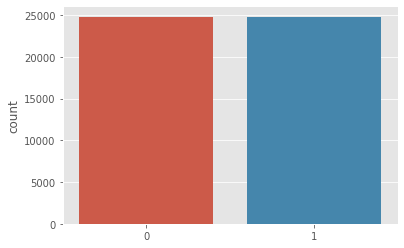

In [44]:
print(Counter(y_train_minmax_resampled))
countplot(y_train_minmax_resampled)

# Random Forest Regression - Borderline SMOTE

## Standard Scaler Model

In [45]:
# Instantiate a random forest model
rf_smote = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)

# Fit to the correct training data
rf_smote.fit(X_train_std_resampled, y_train_std_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.42      0.15      0.22       578

        accuracy                           0.91      6780
       macro avg       0.67      0.57      0.59      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.98097388 0.01902612]
 [0.84948097 0.15051903]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


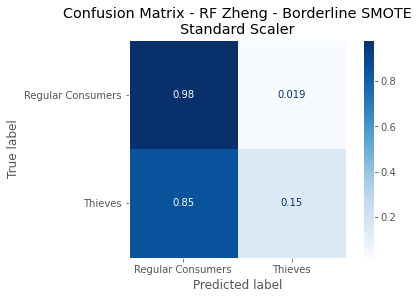

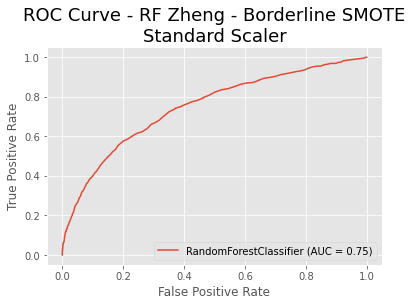

In [46]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - Borderline SMOTE\nStandard Scaler", 
                          normalize_conf_mat="rows")

### By Col

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.42      0.15      0.22       578

        accuracy                           0.91      6780
       macro avg       0.67      0.57      0.59      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.92532319 0.57560976]
 [0.07467681 0.42439024]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


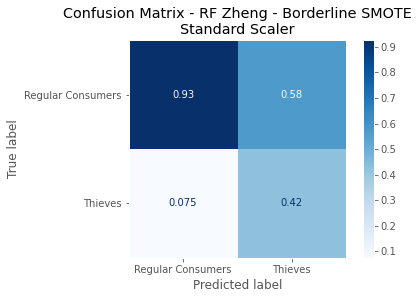

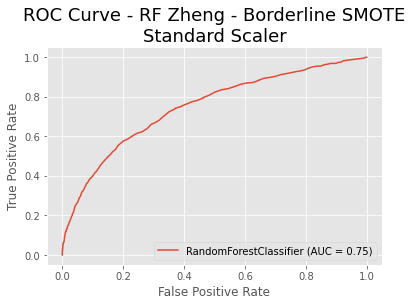

In [47]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - Borderline SMOTE\nStandard Scaler", 
                          normalize_conf_mat="cols")

### By All

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.42      0.15      0.22       578

        accuracy                           0.91      6780
       macro avg       0.67      0.57      0.59      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.89734513 0.01740413]
 [0.07241888 0.01283186]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


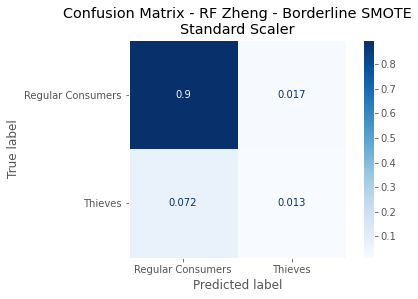

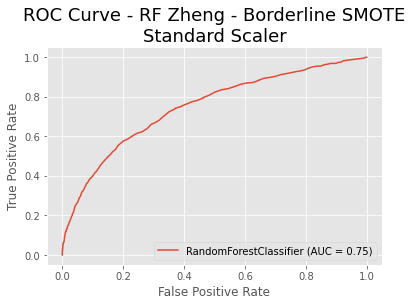

In [48]:
get_classification_result(estimator=rf_smote, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - Borderline SMOTE\nStandard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

In [49]:
rf_smote = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)

# Fit to the correct training data
rf_smote.fit(X_train_minmax_resampled, y_train_minmax_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  8.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.15      0.23       578

        accuracy                           0.91      6780
       macro avg       0.70      0.57      0.59      6780
    weighted avg       0.89      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.98452112 0.01547888]
 [0.85121107 0.14878893]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


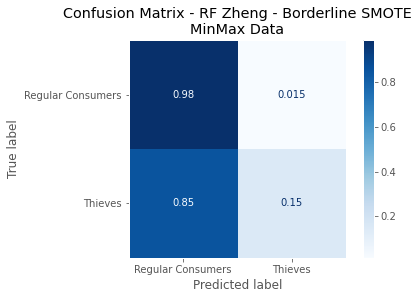

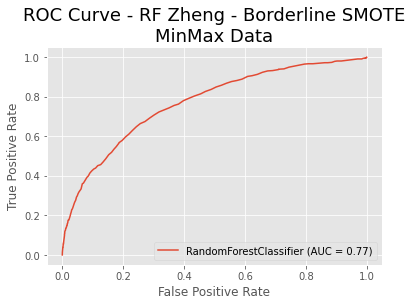

In [50]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - Borderline SMOTE\nMinMax Data", 
                          normalize_conf_mat="rows")

### By Col

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.15      0.23       578

        accuracy                           0.91      6780
       macro avg       0.70      0.57      0.59      6780
    weighted avg       0.89      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.92543195 0.52747253]
 [0.07456805 0.47252747]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


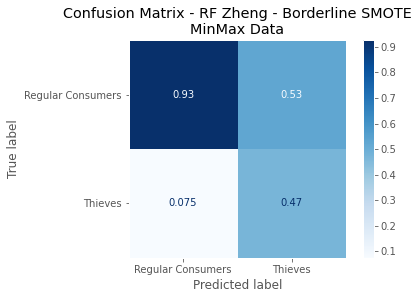

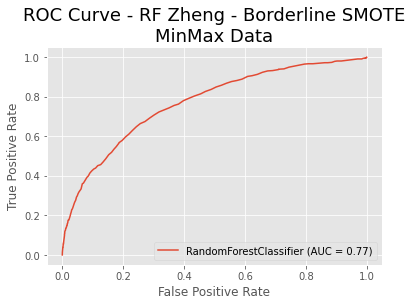

In [51]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - Borderline SMOTE\nMinMax Data", 
                          normalize_conf_mat="cols")

### By All

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.47      0.15      0.23       578

        accuracy                           0.91      6780
       macro avg       0.70      0.57      0.59      6780
    weighted avg       0.89      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.90058997 0.01415929]
 [0.07256637 0.01268437]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


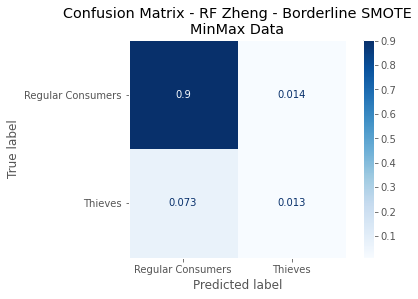

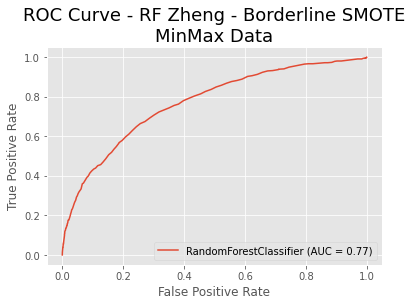

In [52]:
get_classification_result(estimator=rf_smote, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - Borderline SMOTE\nMinMax Data", 
                          normalize_conf_mat="all")

# ADASYN

## Resampling - Standard Scaler Data

In [53]:
adasyn_std = ADASYN() 
X_train_std_resampled, y_train_std_resampled = adasyn_std.fit_resample(
    X_train_1D_std, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Resampling - MinMax Scaler Data

In [54]:
adasyn_minmax = ADASYN() 
X_train_minmax_resampled, y_train_minmax_resampled = adasyn_minmax.fit_resample(
    X_train_1D_minmax, y_train
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Logistic Regression - ADASYN

## Standard Scaler Model

In [55]:
# Instantiate a logistic regression model
rf_adasyn = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)

# Fit to the correct training data
rf_adasyn.fit(X_train_std_resampled, y_train_std_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 12.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.97      0.95      6202
         Thieves       0.36      0.18      0.24       578

        accuracy                           0.90      6780
       macro avg       0.65      0.58      0.60      6780
    weighted avg       0.88      0.90      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.97017091 0.02982909]
 [0.816609   0.183391  ]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


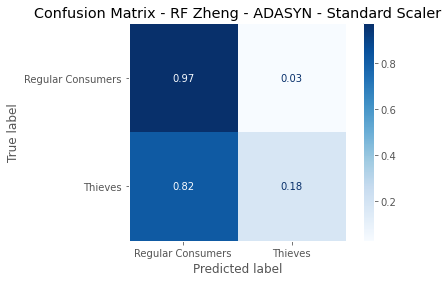

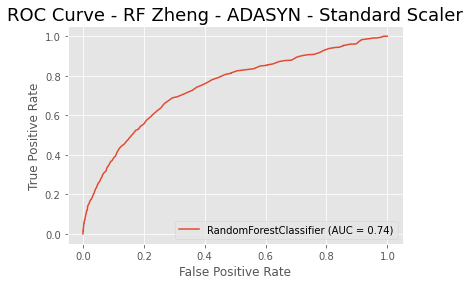

In [56]:
get_classification_result(estimator=rf_adasyn, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - ADASYN - Standard Scaler", 
                          normalize_conf_mat="rows")

### By Col

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.97      0.95      6202
         Thieves       0.36      0.18      0.24       578

        accuracy                           0.90      6780
       macro avg       0.65      0.58      0.60      6780
    weighted avg       0.88      0.90      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.92726152 0.63573883]
 [0.07273848 0.36426117]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


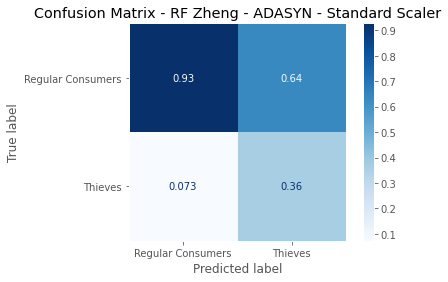

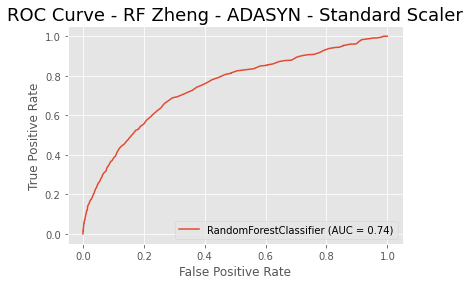

In [57]:
get_classification_result(estimator=rf_adasyn, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - ADASYN - Standard Scaler", 
                          normalize_conf_mat="cols")

### By All

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.97      0.95      6202
         Thieves       0.36      0.18      0.24       578

        accuracy                           0.90      6780
       macro avg       0.65      0.58      0.60      6780
    weighted avg       0.88      0.90      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.88746313 0.02728614]
 [0.06961652 0.01563422]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


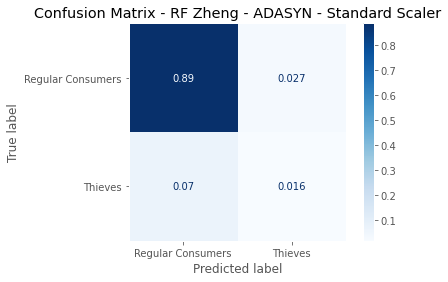

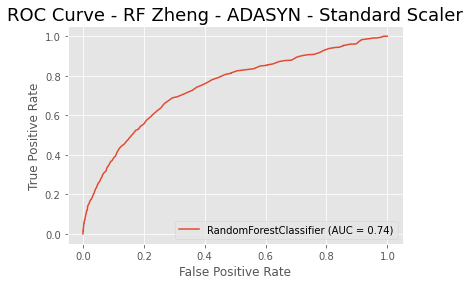

In [58]:
get_classification_result(estimator=rf_adasyn, X=X_val_1D_std, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - ADASYN - Standard Scaler", 
                          normalize_conf_mat="all")

## MinMax Model

In [59]:
rf_adasyn = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                  random_state=0, verbose=2)
# Fit to the correct training data
rf_adasyn.fit(X_train_minmax_resampled, y_train_minmax_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  9.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=2,
                       warm_start=False)

### By Row

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.38      0.15      0.22       578

        accuracy                           0.91      6780
       macro avg       0.65      0.57      0.58      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.97645921 0.02354079]
 [0.84602076 0.15397924]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


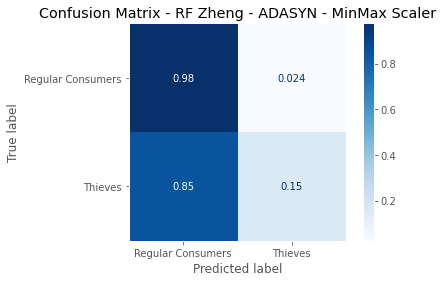

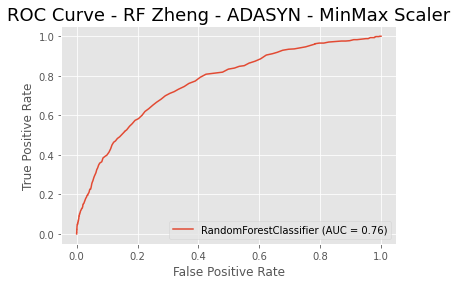

In [60]:
get_classification_result(estimator=rf_adasyn, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - ADASYN - MinMax Scaler", 
                          normalize_conf_mat="rows")

### By Col

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.38      0.15      0.22       578

        accuracy                           0.91      6780
       macro avg       0.65      0.57      0.58      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.92528648 0.6212766 ]
 [0.07471352 0.3787234 ]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


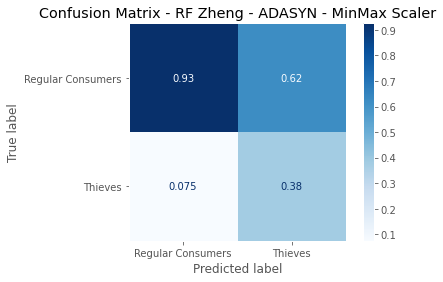

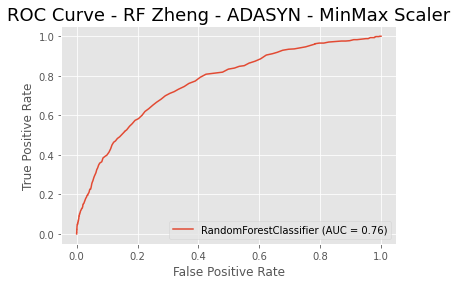

In [61]:
get_classification_result(estimator=rf_adasyn, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - ADASYN - MinMax Scaler", 
                          normalize_conf_mat="cols")

### By All

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.95      6202
         Thieves       0.38      0.15      0.22       578

        accuracy                           0.91      6780
       macro avg       0.65      0.57      0.58      6780
    weighted avg       0.88      0.91      0.89      6780

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.89321534 0.02153392]
 [0.07212389 0.01312684]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


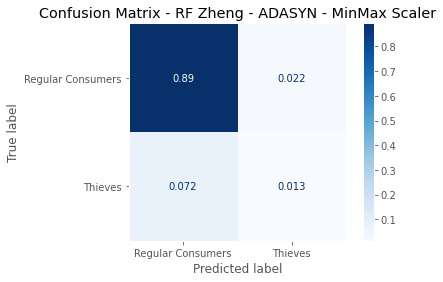

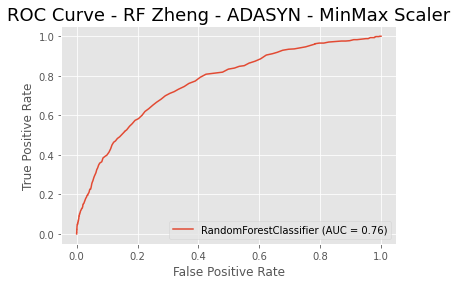

In [62]:
get_classification_result(estimator=rf_adasyn, X=X_val_1D_minmax, 
                          y_true=y_val, 
                          classifier_name="RF Zheng - ADASYN - MinMax Scaler", 
                          normalize_conf_mat="all")